## Test LaSR datasets

In [1]:
import sys
sys.path.append("/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking")
import dataset_utils
from importlib import reload
reload(dataset_utils)


<module 'dataset_utils' from '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking/dataset_utils.py'>

In [2]:
dataset_utils.load_datasets('synthetic', 100, 1e-4, equation_indices=[0])

[SyntheticDataset(idx=0, equation="y = exp(((1.485035504085099 - log(y2)) / (-0.5917667741788188 - y4)) + (sqrt(y1 + y4) + sqrt(y2)))", X=(100, 5), Y=(100,), var_order={'x0': 'y2', 'x1': 'y3', 'x2': 'y5', 'x3': 'y1', 'x4': 'y4'})]

In [3]:
expr = 'x0 * x1 + x2 - sinh(x1)'
dataset_utils.create_dataset_from_expression(expr, 100, 1e-4)


SyntheticDataset(idx=0, equation="y = x0 * x1 + x2 - sinh(x1)", X=(100, 3), Y=(100,), var_order={'x0': 'x0', 'x1': 'x1', 'x2': 'x2'})

Note: Expressions from synthetic dataset without log or sqrt are:
[5, 9, 16, 20, 25, 31, 32, 36, 39]

## PySR integration tests

In [4]:
from matplotlib import pyplot as plt

In [5]:
from pysr import PySRRegressor, TensorBoardLoggerSpec
from pysr_interface_utils import get_mutation_stats, reset_mutation_stats
import numpy as np
import sys
sys.path.append("/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking")
from importlib import reload
import dataset_utils
reload(dataset_utils)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


<module 'dataset_utils' from '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking/dataset_utils.py'>

In [75]:
def eval_equation(X, y, n_iterations=10, early_stopping_condition=1e-8):
    custom_loss = """
    function eval_loss(tree, dataset::Dataset{T,L}, options)::L where {T,L}
        prediction, flag = eval_tree_array(tree, dataset.X, options)
        if !flag
            return L(Inf)
        end
        return sum( (1000 .* (prediction .- dataset.y) ) .^ 2) / dataset.n
    end
    """
    logger_spec = TensorBoardLoggerSpec(
        log_dir="logs/run",
        log_interval=10,  # Log every 10 iterations
    )

    model = PySRRegressor(
        niterations=n_iterations,
        binary_operators=["+", "*", "-", "/"],
        unary_operators=[
            "cos",
            "exp",
            "sin",
            "tanh",
            "cosh",
            "sinh"
        ],
        precision=64,
        neural_options=dict(
            active=True,
            model_path="/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/dev/ONNX/onnx-models/model-zwrgtnj0.onnx",
            sampling_eps=0.01,
            subtree_min_nodes=2,
            subtree_max_nodes=10,
        ),
        weight_neural_mutate_tree=0.0,
        # elementwise_loss="loss(prediction, target) = (prediction - target)^2",
        loss_function=custom_loss,
        early_stop_condition=f"f(loss, complexity) = (loss < {early_stopping_condition:e})",
        logger_spec=logger_spec,
    )
    model.fit(X, y)
    return model

In [76]:
dataset = dataset_utils.load_datasets('synthetic', num_samples=2000, noise=0, equation_indices=[9])[0]
dataset.equation

'y = y1 * (((y1 * y1) / (2.189911201366985 / cos((1.2114819663272414 - y4) + -0.20111570724898717))) / exp(-0.08661496242802426 * y5))'

In [22]:
expr = 'cosh(x0)/(x0+2)+x0 + (x1 - sinh(x1))/exp(x1+3) - 5'
dataset = dataset_utils.create_dataset_from_expression(expr, 100, 0)
dataset.equation

'y = cosh(x0)/(x0+2)+x0 + (x1 - sinh(x1))/exp(x1+3) - 5'

In [77]:
reset_mutation_stats()
model = eval_equation(dataset.X, dataset.Y, n_iterations=40, early_stopping_condition=1e-8)

/Users/luis/opt/anaconda3/envs/simexpr-arm64/lib/python3.12/site-packages/pysr/sr.py:2785: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 5.690e+04
Progress: 203 / 1240 total iterations (16.371%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.579e+10  3.604e+01  y = x₀
2           4.568e+10  2.502e-03  y = sin(x₃)
3           4.562e+10  1.130e-03  y = exp(sin(x₃))
4           3.049e+10  4.032e-01  y = sin(x₃) / 0.0057007
6           2.361e+10  1.279e-01  y = sin(x₃ + 0.57549) * 215.62
8           1.639e+10  1.825e-01  y = sin(x₃) * (x₀ * (x₀ * 5.0991))
10          3.233e+09  8.115e-01  y = (x₀ * (cos(x₃ - 1.0027) * x₀)) * 6.2146
11          2.686e+09  1.854e-01  y = (x₀ * (x₀ * x₀)) * tanh(cos(x₃ - 1.0118))
12          2.379e+09  1.213e-01  y = x₀ * (x₀ * ((x₀ / 1.3345) * cos(1.0582 - x₃)))
13          2.254e+09  5.381e-02  y = ((x₀ * x₀) * (tanh(cos(1.0105 - x₃)) * 0.90951)) * x

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 4.790e+04
Progress: 496 / 1240 total iterations (40.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.579e+10  3.604e+01  y = x₀
2           4.568e+10  2.502e-03  y = sin(x₃)
3           4.562e+10  1.130e-03  y = exp(sin(x₃))
4           3.049e+10  4.032e-01  y = sin(x₃) / 0.0057007
6           2.001e+10  2.105e-01  y = (x₀ * sin(x₃)) * 37.036
8           8.607e+09  4.218e-01  y = x₀ * (cos(0.99796 - x₃) * 45.147)
9           6.058e+09  3.511e-01  y = exp(x₀ * 0.69015) * cos(x₃ - 1.0203)
10          3.233e+09  6.281e-01  y = ((cos(x₃ - -55.546) * x₀) * 6.2146) * x₀
11          2.686e+09  1.854e-01  y = (x₀ * x₀) * (x₀ * tanh(cos(x₃ - 1.0118)))
12          2.253e+09  1.758e-01  y = x₀ * (cos(1.0078 - x₃) * ((x₀ * 0.74465) * x₀))
14          9

In [16]:
model.get_hof().loss.min()


1673.579990325271

In [17]:
stats = get_mutation_stats()
in_sizes, out_sizes = stats['subtree_in_sizes'], stats['subtree_out_sizes']

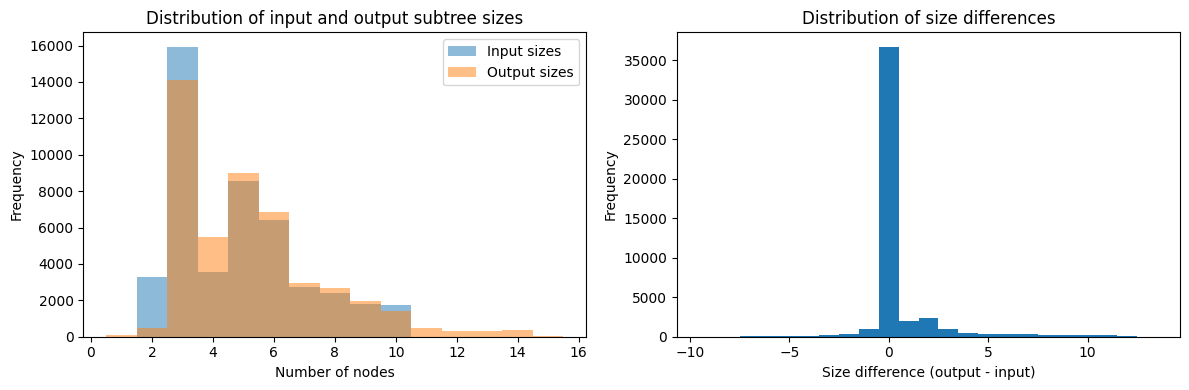

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot histograms of in and out sizes on first subplot
ax1.hist(in_sizes, alpha=0.5, label='Input sizes', bins=range(min(in_sizes), max(in_sizes)+2), align='left')
ax1.hist(out_sizes, alpha=0.5, label='Output sizes', bins=range(min(out_sizes), max(out_sizes)+2), align='left')
ax1.set_xlabel('Number of nodes')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of input and output subtree sizes')
ax1.legend()

# Plot histogram of differences on second subplot
differences = [out - in_ for out, in_ in zip(out_sizes, in_sizes)]
ax2.hist(differences, bins=range(min(differences), max(differences)+2), align='left')
ax2.set_xlabel('Size difference (output - input)')
ax2.set_ylabel('Frequency') 
ax2.set_title('Distribution of size differences')

plt.tight_layout()
plt.show()


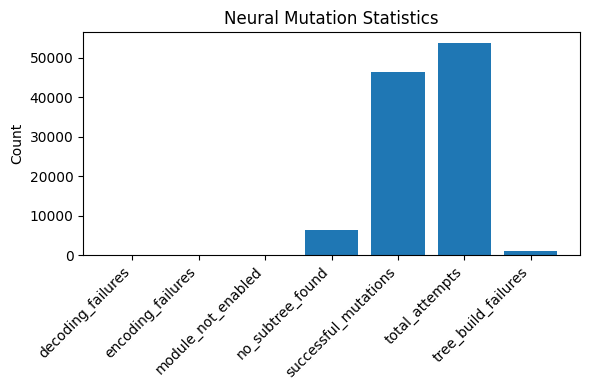

In [19]:
# Get counts for each stat type
count_stats = {k: v for k, v in stats.items() if isinstance(v, int)} 

# Create bar plot
plt.figure(figsize=(6, 4))
plt.bar(count_stats.keys(), count_stats.values())
plt.xticks(rotation=45, ha='right')
plt.title('Neural Mutation Statistics')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [14]:
count_stats

{'decoding_failures': 0,
 'encoding_failures': 0,
 'module_not_enabled': 0,
 'no_subtree_found': 19,
 'successful_mutations': 2416,
 'total_attempts': 2458,
 'tree_build_failures': 23}

## Reading TensorBoard data

In [88]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [43]:
event_acc = EventAccumulator('/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking/logs/run_10')
event_acc.Reload()
# Show all tags in the log file
print(event_acc.Tags())

# # E. g. get wall clock, number of steps and value for a scalar 'Accuracy'
# w_times, step_nums, vals = zip(*event_acc.Scalars('Accuracy'))

{'images': [], 'audio': [], 'histograms': ['search/data/population/complexities'], 'scalars': ['search/data/summaries/min_loss', 'search/data/summaries/pareto_volume', 'search/data/num_evals', 'search/data/equations/complexity=6/loss', 'search/data/equations/complexity=12/loss', 'search/data/equations/complexity=20/loss', 'search/data/equations/complexity=8/loss', 'search/data/equations/complexity=14/loss', 'search/data/equations/complexity=16/loss', 'search/data/equations/complexity=3/loss', 'search/data/equations/complexity=10/loss', 'search/data/equations/complexity=15/loss', 'search/data/equations/complexity=13/loss', 'search/data/equations/complexity=23/loss', 'search/data/equations/complexity=2/loss', 'search/data/equations/complexity=21/loss', 'search/data/equations/complexity=24/loss', 'search/data/equations/complexity=19/loss', 'search/data/equations/complexity=25/loss', 'search/data/equations/complexity=17/loss', 'search/data/equations/complexity=5/loss', 'search/data/equatio

In [44]:
event_acc.Tags()['scalars']

['search/data/summaries/min_loss',
 'search/data/summaries/pareto_volume',
 'search/data/num_evals',
 'search/data/equations/complexity=6/loss',
 'search/data/equations/complexity=12/loss',
 'search/data/equations/complexity=20/loss',
 'search/data/equations/complexity=8/loss',
 'search/data/equations/complexity=14/loss',
 'search/data/equations/complexity=16/loss',
 'search/data/equations/complexity=3/loss',
 'search/data/equations/complexity=10/loss',
 'search/data/equations/complexity=15/loss',
 'search/data/equations/complexity=13/loss',
 'search/data/equations/complexity=23/loss',
 'search/data/equations/complexity=2/loss',
 'search/data/equations/complexity=21/loss',
 'search/data/equations/complexity=24/loss',
 'search/data/equations/complexity=19/loss',
 'search/data/equations/complexity=25/loss',
 'search/data/equations/complexity=17/loss',
 'search/data/equations/complexity=5/loss',
 'search/data/equations/complexity=9/loss',
 'search/data/equations/complexity=1/loss',
 'sear

In [64]:
event_acc.Scalars('search/data/summaries/min_loss')[0]


ScalarEvent(wall_time=1736525198.557605, step=1, value=14801625088.0)

In [67]:
import pandas as pd
losses = np.array([(e.wall_time, e.step, e.value) for e in event_acc.Scalars('search/data/summaries/min_loss')])

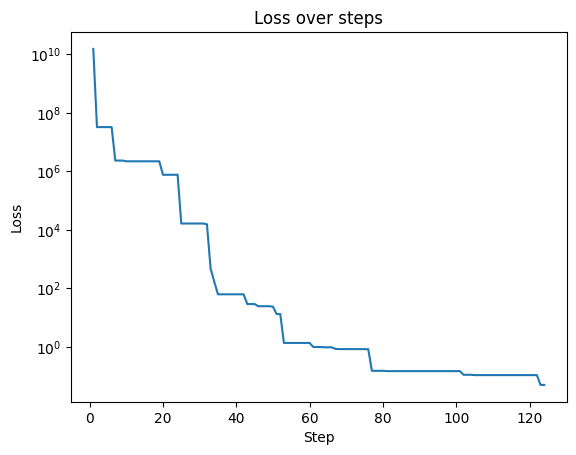

In [71]:
plt.plot(losses[:, 1], losses[:, 2])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over steps')
plt.yscale('log')
plt.show()


## Choosing operators

In [78]:
fpath = '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking/data/FeynmanEquations.csv'
df = pd.read_csv(fpath)
df.head()


,Filename,Number,Output,Formula,# variables,v1_name,v1_low,v1_high,v2_name,v2_low,...,v7_high,v8_name,v8_low,v8_high,v9_name,v9_low,v9_high,v10_name,v10_low,v10_high
0,I.6.2a,1.0,f,exp(-theta**2/2)/sqrt(2*pi),1.0,theta,1.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I.6.2,2.0,f,exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma),2.0,sigma,1.0,3.0,theta,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I.6.2b,3.0,f,exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*...,3.0,sigma,1.0,3.0,theta,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I.8.14,4.0,d,sqrt((x2-x1)**2+(y2-y1)**2),4.0,x1,1.0,5.0,x2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I.9.18,5.0,F,G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2),9.0,m1,1.0,2.0,m2,1.0,...,2.0,z1,3.0,4.0,z2,1.0,2.0,NaN,NaN,NaN


In [84]:
'log' in df.Formula.str.cat()

False

In [87]:
def find_remaining_ops(formulas):
    operators = ['exp', '*', '**', '/', '+', '-', 'sqrt', 'sin', 'cos', 'tan', 'sinh', 'cosh', 'tanh']
    
    # First count the known operators
    operator_counts = {}
    for formula in formulas.dropna():
        for op in operators:
            # For *, don't count occurrences that are part of **
            if op == '*':
                count = formula.count('*') - 2 * formula.count('**')
            else:
                count = formula.count(op)
            if count > 0:
                operator_counts[op] = operator_counts.get(op, 0) + count
    
    print("Known operator counts:")
    print(pd.Series(operator_counts).sort_values(ascending=False))
    
    # Then remove all known operators and see what's left
    print("\nRemainder after removing known operators:")
    remaining = formulas.copy()
    for op in operators:
        remaining = remaining.str.replace(op, ' ', regex=False)
    
    # Remove numbers, variables, spaces and parentheses
    remaining = remaining.str.replace(r'[0-9]', '', regex=True)
    remaining = remaining.str.replace(r'[a-zA-Z]', '', regex=True)
    remaining = remaining.str.replace(r'[\s\(\)]', '', regex=True)
    remaining = remaining.str.replace('.', '', regex=False)
    
    # Print unique remaining characters
    print("Unique remaining characters:", sorted(set(''.join(remaining.dropna()))))

find_remaining_ops(df.Formula)

Known operator counts:
*       255
/       138
**       87
-        45
+        30
sqrt     18
sin      11
cos      11
exp      10
tan       1
tanh      1
dtype: int64

Remainder after removing known operators:
Unique remaining characters: ['_']


In [86]:
df.Formula.dropna()

0                           exp(-theta**2/2)/sqrt(2*pi)
1           exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma)
2     exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*...
3                           sqrt((x2-x1)**2+(y2-y1)**2)
4            G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)
                            ...                        
95                           (h/(2*pi))**2/(2*E_n*d**2)
96                                     2*pi*alpha/(n*d)
97                            beta*(1+alpha*cos(theta))
98    -m*q**4/(2*(4*pi*epsilon)**2*(h/(2*pi))**2)*(1...
99                                   -rho_c_0*q*A_vec/m
Name: Formula, Length: 100, dtype: object

## Reading whole benchmark's Tensorboard data

In [89]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

Steps per test_ run: [124, 124, 124, 124, 124]
Steps per test-neural_ run: [124, 124, 124, 124, 124]
Steps per no-noise_vanilla_ run: [124, 124, 124, 124, 124]

test_ losses shape: (124, 5)

test-neural_ losses shape: (124, 5)

no-noise_vanilla_ losses shape: (124, 5)


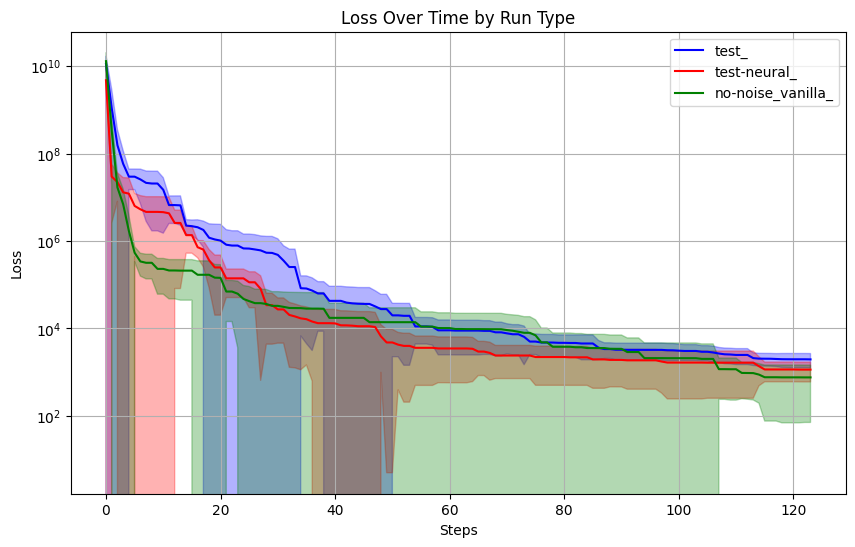

In [103]:
def load_tensorboard_data(log_dir, prefixes):
    # Convert single prefix to list for consistency
    if isinstance(prefixes, str):
        prefixes = [prefixes]
        
    all_losses = {}
    for prefix in prefixes:
        matching_dirs = [d for d in os.listdir(log_dir) if d.startswith(prefix)]
        
        losses = []
        for dir_name in matching_dirs:
            dir_path = os.path.join(log_dir, dir_name)
            event_acc = EventAccumulator(dir_path)
            event_acc.Reload()
            
            try:
                loss_events = event_acc.Scalars('search/data/summaries/min_loss')
                dir_losses = np.array([(e.wall_time, e.step, e.value) for e in loss_events])
                losses.append(dir_losses)
            except KeyError:
                print(f"No loss data found in {dir_name}")
                continue
                
        all_losses[prefix] = losses

    # Check that all runs have same number of steps
    for prefix, losses in all_losses.items():
        n_steps = [x.shape[0] for x in losses]
        print(f"Steps per {prefix} run:", n_steps)

    # Get just the loss values and combine into single array for each prefix
    loss_arrays = {}
    for prefix, losses in all_losses.items():
        if not losses:  # Skip if no data for this prefix
            continue
        loss_array = np.zeros((losses[0].shape[0], len(losses)))
        for i in range(len(losses)):
            loss_array[:, i] = losses[i][:, 2]  # 3rd column is loss value
        loss_arrays[prefix] = loss_array
        print(f"\n{prefix} losses shape:", loss_array.shape)

    # Plot losses over time with error margins
    plt.figure(figsize=(10, 6))

    # Use a different color for each prefix
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    for (prefix, losses), color in zip(loss_arrays.items(), colors):
        mean = np.mean(losses, axis=1)
        std = np.std(losses, axis=1)
        steps = np.arange(len(mean))
        
        plt.plot(steps, mean, label=prefix, color=color)
        plt.fill_between(steps,
                        mean - std,
                        mean + std,
                        alpha=0.3,
                        color=color)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Loss Over Time by Run Type')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return loss_arrays

# Example usage:
prefixes = ['test_', 'test-neural_', 'no-noise_vanilla_']
losses = load_tensorboard_data('/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking/logs', prefixes)